### Preliminary Exploratory Data Analysis# What makes a Champion?
## DSCI 100 Group 15 Project Proposal

Arimoto, Yuhei - 36561967 | 
Dufour-Nogueira, Emma Héloïse - 34570614 | 
Huang, Felix - 15914948 | 
Tan Palanca, Katrina Marie (Kim) - 98857568

### Introduction

- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

### Data Analysis

#### Tidying

First and foremost, the data must be read into R and tidied according to our needs in order to apply any form of data analysis methods to it.

##### Importing Relevant Libraries

In [210]:
library(tidyverse)
library(tidymodels)
library(GGally)

set.seed(1234)

#this library() function loads the tidymodels, repr, tidyverse, and GGally libraries into R
#the set.seed() function sets the seed for the project

Each library offers its own unique set of functions that we can use later on the analysis:
- _tidyverse_: the main source of a multitude of functions to load, modify, and plot the data;
- _tidymodels_: the source of all functions pertaining to classifier-building in this analysis;
- _GGally_: the source of the _ggpairs()_ function, relevant later in the project.

##### Reading the Data from the Web into R

In [211]:
data <- read_csv("https://raw.githubusercontent.com/kimtanpalanca/dsci_group_15/main/atp2017-2019.csv")
#the tennnis player data is referred to as the object "data" throughout this analysis

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



Using the _read_csv()_ function from the tidyverse library, the data can be read from the web directly into R. In this case, the data is stored on an online GitHub repository.

##### Selecting and Tidying Relevant Columns

In [212]:
data <- data%>%
    select(winner_name,
           w_ace,
           w_df, 
           w_svpt, 
           w_SvGms, 
           w_1stIn, 
           w_1stWon, 
           loser_name)%>%
#the columns relevant to our analysis are selected using this select() function
    filter(!is.na(winner_name),
           !is.na(loser_name),
           !is.na(w_ace),
           !is.na(w_df),
           !is.na(w_svpt),
           !is.na(w_SvGms),
           !is.na(w_1stIn),
           !is.na(w_1stWon))
#the !is.na() argument in the filter() function eliminates NA values in the relevant columns

head(data, 10)

winner_name,w_ace,w_df,w_svpt,w_SvGms,w_1stIn,w_1stWon,loser_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Kei Nishikori,3,3,77,13,44,31,Daniil Medvedev
Daniil Medvedev,10,1,52,10,33,28,Jo Wilfried Tsonga
Kei Nishikori,2,2,47,8,33,26,Jeremy Chardy
Jo Wilfried Tsonga,12,2,68,11,43,34,Alex De Minaur
Daniil Medvedev,12,3,105,16,68,48,Milos Raonic
Jeremy Chardy,10,8,94,16,58,44,Yasutaka Uchiyama
Kei Nishikori,5,2,59,12,47,37,Grigor Dimitrov
Jo Wilfried Tsonga,11,3,64,10,37,30,Taro Daniel
Alex De Minaur,1,1,49,9,38,29,Jordan Thompson


##### Table 1: First 10 Rows of the _data_ Tibble (w_ace: number of aces scored by winning player; w_df: number of double faults scored by winning player; w_svpt: number of points earned by serving by winning player; w_SvGms: number of service games; w_1stIn: number of first serves executed by winning player; w_1stWon: number of successful first serves executed by winning player; winner_name: name of winning player; loser_name: name of losing player)

The objective of this analysis is to predict the win probability of a tennis player based on their serving skill. Subsequently, only columns directly related to serving were kept for the final analysis:
- _w__ace_ (number of aces ("a serve that successfully lands in the service box and does not touch the receiving player’s racquet" (Crim, n.d.)) scored by winning player);
- _w__df_ (number of double faults ("two consecutive serving [mistakes] that result in the loss of a point" (double fault, n.d.)) scored by winning player);
- _w__svpt_ (number of points earned by serving (such serves will hereafter be referred to as "successful serves") by winning player);
- _w__SvGms_ (number of service games ("a game in which a particular player serves" (Farlex Trivia Dictionary, 2012)) won by player);
- _w__1stIn_ (number of first serves executed by winning player);
- _w__1stWon_ (number of successful first serves executed by winning player).

_w__2ndWon_ (number of second serves executed by winning player) was not kept due to its redundancy (in comparison to w_1stWon) and the fact that a successful first serve directly suggests serving skill while a successful second serve has more nebulous implications in this regard (i.e. the player may have gotten lucky).

Furthermore, for classification purposes, the two following columns were also kept:
- _winner_name_ (name of winning player);
- _loser_name_ (name of losing player).

These two columns will become more relevant in the following phase of tidying the data.

The columns specified above were also filtered for NA ("non-applicable") arguments so as to ensure the quantitative nature of the data using the !is.na() argument in the filter() function - both tidyverse components.

##### Gathering the Winner Data

In [213]:
player_data <- data%>%
    select(winner_name, 
           loser_name)
#this code creates a dataframe containing all of the players' names in the original data (both winners and losers)
#the frequency of repetition of these names is equivalent to the number of matches that each player partook in
#(e.g. player X appears twice, he took part in 2 matches)

player_data_column <- data.frame(all_players=unlist(player_data, use.names = FALSE))
#this code creates a single column containing all of the players names

winner_names <- player_data%>%
    group_by(winner_name)%>%
    summarize(n_wins = n())
#this code creates a table containing only the winners names as well as the number of wins of each winning player

n_games_all <- player_data_column%>%
    group_by(all_players)%>%
    summarize(n_games = n())%>%
    subset(all_players %in% winner_names$winner_name)
#this code adds a column to player_data_column containing the number of games each player partook in
#it then extracts the rows which contain player names present in winner_names (i.e. restricts the data to only winners)

winner_data <- tibble(winner_name = winner_names$winner_name,
                      n_wins = winner_names$n_wins, 
                      n_games = n_games_all$n_games)%>%
    mutate(percentage_win = (n_wins/n_games)*100)
#this code creates a tibble containing the winners' names, their number of matches won, and the total number of matches they partook in
#the mutate() function then adds a column detailing the win ratios of each winner in relation to their total number of matches played in (win/total)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



As previously explained, the response variable of this analysis is intended to be the win probability of a winning player. In other words:

$\frac{Number~of~Wins~Earned}{Total~Number~of~Games~Played}*100$

The code above calculates this value for each winning player:

   1) _player_data_ gathers _winner_name_ and _loser_name_ in a single tibble;
   
   2) _player_data_column_ combines these two columns into a single column (i.e. a list of names);
   
   3) _winner_names_ extracts only the _winner_name_ column from _player_data_ and, using the summarize() function from tidyverse, creates a column containing the number of times each player names appear (i.e. the number of times each player has won);
   
   4) _n__games_all_, similarly to _winner_names_ adds a column to _player_data_column_ containing the number of appearances of each player (i.e. the total number of games played by each player) before extracting only the rows containing player names present in _winner_names_ (i.e. extracting rows pertaining only to winners (since some of the players have lost games as well));
   
   5) _winner_data_ combines the relevant columns (_winner_name_, _n__wins_ (number of wins), and _n__games_ (total games played)) before calculating the win probability for each winner, gathered in the _percentage_win_ column.    

##### Tidying the Data as a Whole

In [214]:
data <- data%>%
    group_by(winner_name)%>%
    summarize(number_of_wins = n(),
              avg_ace = mean(w_ace),
              avg_df = mean(w_df),
              avg_svpt = mean(w_svpt),
              avg_svgm = mean(w_SvGms),
              avg_first = mean(w_1stIn),
              avg_first_won = mean(w_1stWon))%>%
#removing repeats in data by averaging all the values over three years
    bind_cols(winner_data)%>%
#combining the relevant columns in winner_data with the data dataframe
    rename(winner_name = winner_name...1)%>%
    mutate(total_avg_svpt = avg_svpt + avg_svgm,
#summing service points and service games (both are points earned by serving)
           fst_srv_prct = (avg_first_won/avg_first)*100)%>%
#calculating the percentage of successful first serves
     filter(n_games > 50)%>%
#filtering for winners who play at least 50 games in order to eliminate outliers
    select(percentage_win,
           avg_ace, 
           avg_df, 
           total_avg_svpt, 
           fst_srv_prct)%>%
#selecting relevant variables
    mutate(avg_ace = round(avg_ace, 2),
           avg_df = round(avg_df, 2), 
           total_avg_svpt = round(total_avg_svpt, 2), 
           fst_srv_prct = round(fst_srv_prct, 2),
           percentage_win = round(percentage_win, 2))
#converting variables to appropriate data types and rounding to 2 decimal places

head(data, 10)

`summarise()` ungrouping output (override with `.groups` argument)

New names:
* winner_name -> winner_name...1
* winner_name -> winner_name...9



percentage_win,avg_ace,avg_df,total_avg_svpt,fst_srv_prct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
51.27,6.02,2.27,92.95,73.35
47.06,3.97,2.32,96.43,71.86
59.26,4.58,2.41,89.00,75.87
69.35,9.06,3.48,88.41,77.35
50.98,9.31,2.17,90.87,78.18
49.56,7.25,2.73,97.30,76.72
55.00,6.70,3.39,91.45,76.13
63.16,7.22,2.89,99.75,74.95
51.90,10.17,5.11,94.68,79.38


##### Table 2: First 10 Rows of the _data_ Tibble (_percentage_win_: percentage of wins earned by winning player; _avg_ace_: average number of aces scored by winning player; _avg_df_: average number of double faults scored by winning player; _total_avg_svpt_: average total number of successful serves by winning player; _fst_srv_prct_: percentage of successful first serves by winning player)

Having calculated the win probability of each winning player, the data can now be tidied into a single, self-contained table.

Due to the fact that the original data spans over three years, certain players are recurrent, causing repeats in the data. To prevent this, the mean of all predictor variables was calculated:
- _avg_ace_: average number of aces of winning player;
- _avg_df_: average number of double faults by winning player;
- _avg_svpt_: average number of service points earned by winning player;
- _avg_svgm_: average number of service games won by player;
- _avg_first_: average number of first serves executed by winning player;
- _avg_first_won_: average number of successful first serves by winning player.

To remove the aforementioned repeats, a new column was created containing the number of appearances of each winner name (_number_of_wins_) which is then removed to accomodate the previously prepared _winner_data_. Furthermore, to avoid analyzing the data of players who have only played a few games (thus skewing the classifier and data anlysis), the data was filtered to only include players having player at least 50 games over three years.

Given that both _avg_svpt_ and _avg_svgm_ refer to points earned by serving, the total number of points earned by serving is given by their sum, gathered in the _total_avg_svpt_ column. Similarly, the _avg_first_ and _avg_first_won_ columns are combined (the latter being divided by the latter and multiplied by 100) to give the _fst_srv_prct_ column: the percentage of successful first serves by the winning player.

Once rounded to avoid unnecessarily large numbers, the tidied data now consists of the following quantitative columns:
- _percentage_win_;
- _avg_ace_;
- _avg_df_;
- _total_avg_svpt_;
- _fst_srv_prct_.


#### Exploration and Visualization

##### Splitting the Data into Training and Testing Sets

In [215]:
data_split <- initial_split(data, prop = 0.75, strata = percentage_win)
data_train <- training(data_split)
data_test <- testing(data_split)

#randomly splits 75% of the data into the training and testing sets using
#percentage_win as the strata

The exploration of the data is to be done using the training data (_data_train_) so as to give an idea of what an analysis of this information could result in given that _percentage_win_ is our response variable and all other variables are predictors.

##### Summarizing Key Details of the Training Data

In [216]:
train_summmary <- data_train%>%
    tibble(number_of_players = nrow(data_train),                                                   #total number of winners in the data
           avg_ace_n = mean(avg_ace),                                                              #average number of aces of each winner
           avg_df_n = mean(avg_df),                                                                #average number of double faults by each winner
           avg_total_avg_svpt = mean(total_avg_svpt),                                              #average total number of points earned by serving of each winner
           avg_fst_srv_prct = mean(fst_srv_prct),                                                  #average percentage of succesful first serves of each winner
           top_win_p = max(percentage_win),                                                        #highest win ratio in the data 
           bottom_win_p = min(percentage_win))%>%                                                  #lowest win ratio in the data
    select(number_of_players, 
           avg_ace_n, avg_df_n, 
           avg_total_avg_svpt, 
           avg_fst_srv_prct, 
           top_win_p, 
           bottom_win_p)%>%
#the select() function keeps relevant columns
    slice(1)%>%
    mutate(number_of_players = as.double(number_of_players), 
           avg_ace_n = round(avg_ace_n, 2),
           avg_df_n = round(avg_df_n, 2), 
           avg_total_avg_svpt = round(avg_total_avg_svpt, 2), 
           avg_fst_srv_prct = round(avg_fst_srv_prct, 2))
#converting variables to appropriate data types and rounding to 2 decimal places

train_summmary

number_of_players,avg_ace_n,avg_df_n,avg_total_avg_svpt,avg_fst_srv_prct,top_win_p,bottom_win_p
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
80,7.44,2.78,93.74,76.28,88.24,29.31


##### Table 3: Summary of Key Details in the Training Data (_number_of_players_: number of winning players; _avg_ace_n_: mean of the average number of aces; _avg_df_n_: mean of the average number of double faults; _avg_total_avg_svpt_: mean of the average number of total service points; _avg_fst_srv_prct_: mean of the average percentage of successful first serves; _top_win_p_: highest win probability value; _bottom_win_p_: lowest win probability value)

Given that a KNN regression model is to be created in this analysis, the means of the predictor variables are interesting points to note. Furthermore, knowing the number of players in the training set gives us an idea of the size of the data that will be analyzed (which may influence the classifier's predictive accuracy).

The highest and lowest win percentage values are also included as an approximation of the skill level of the players in the data: it would not be very useful to examine the serving skill of a player with an extremely low win ratio.

##### Visualizing the Relationships Between Each Predictor and the Response Variable

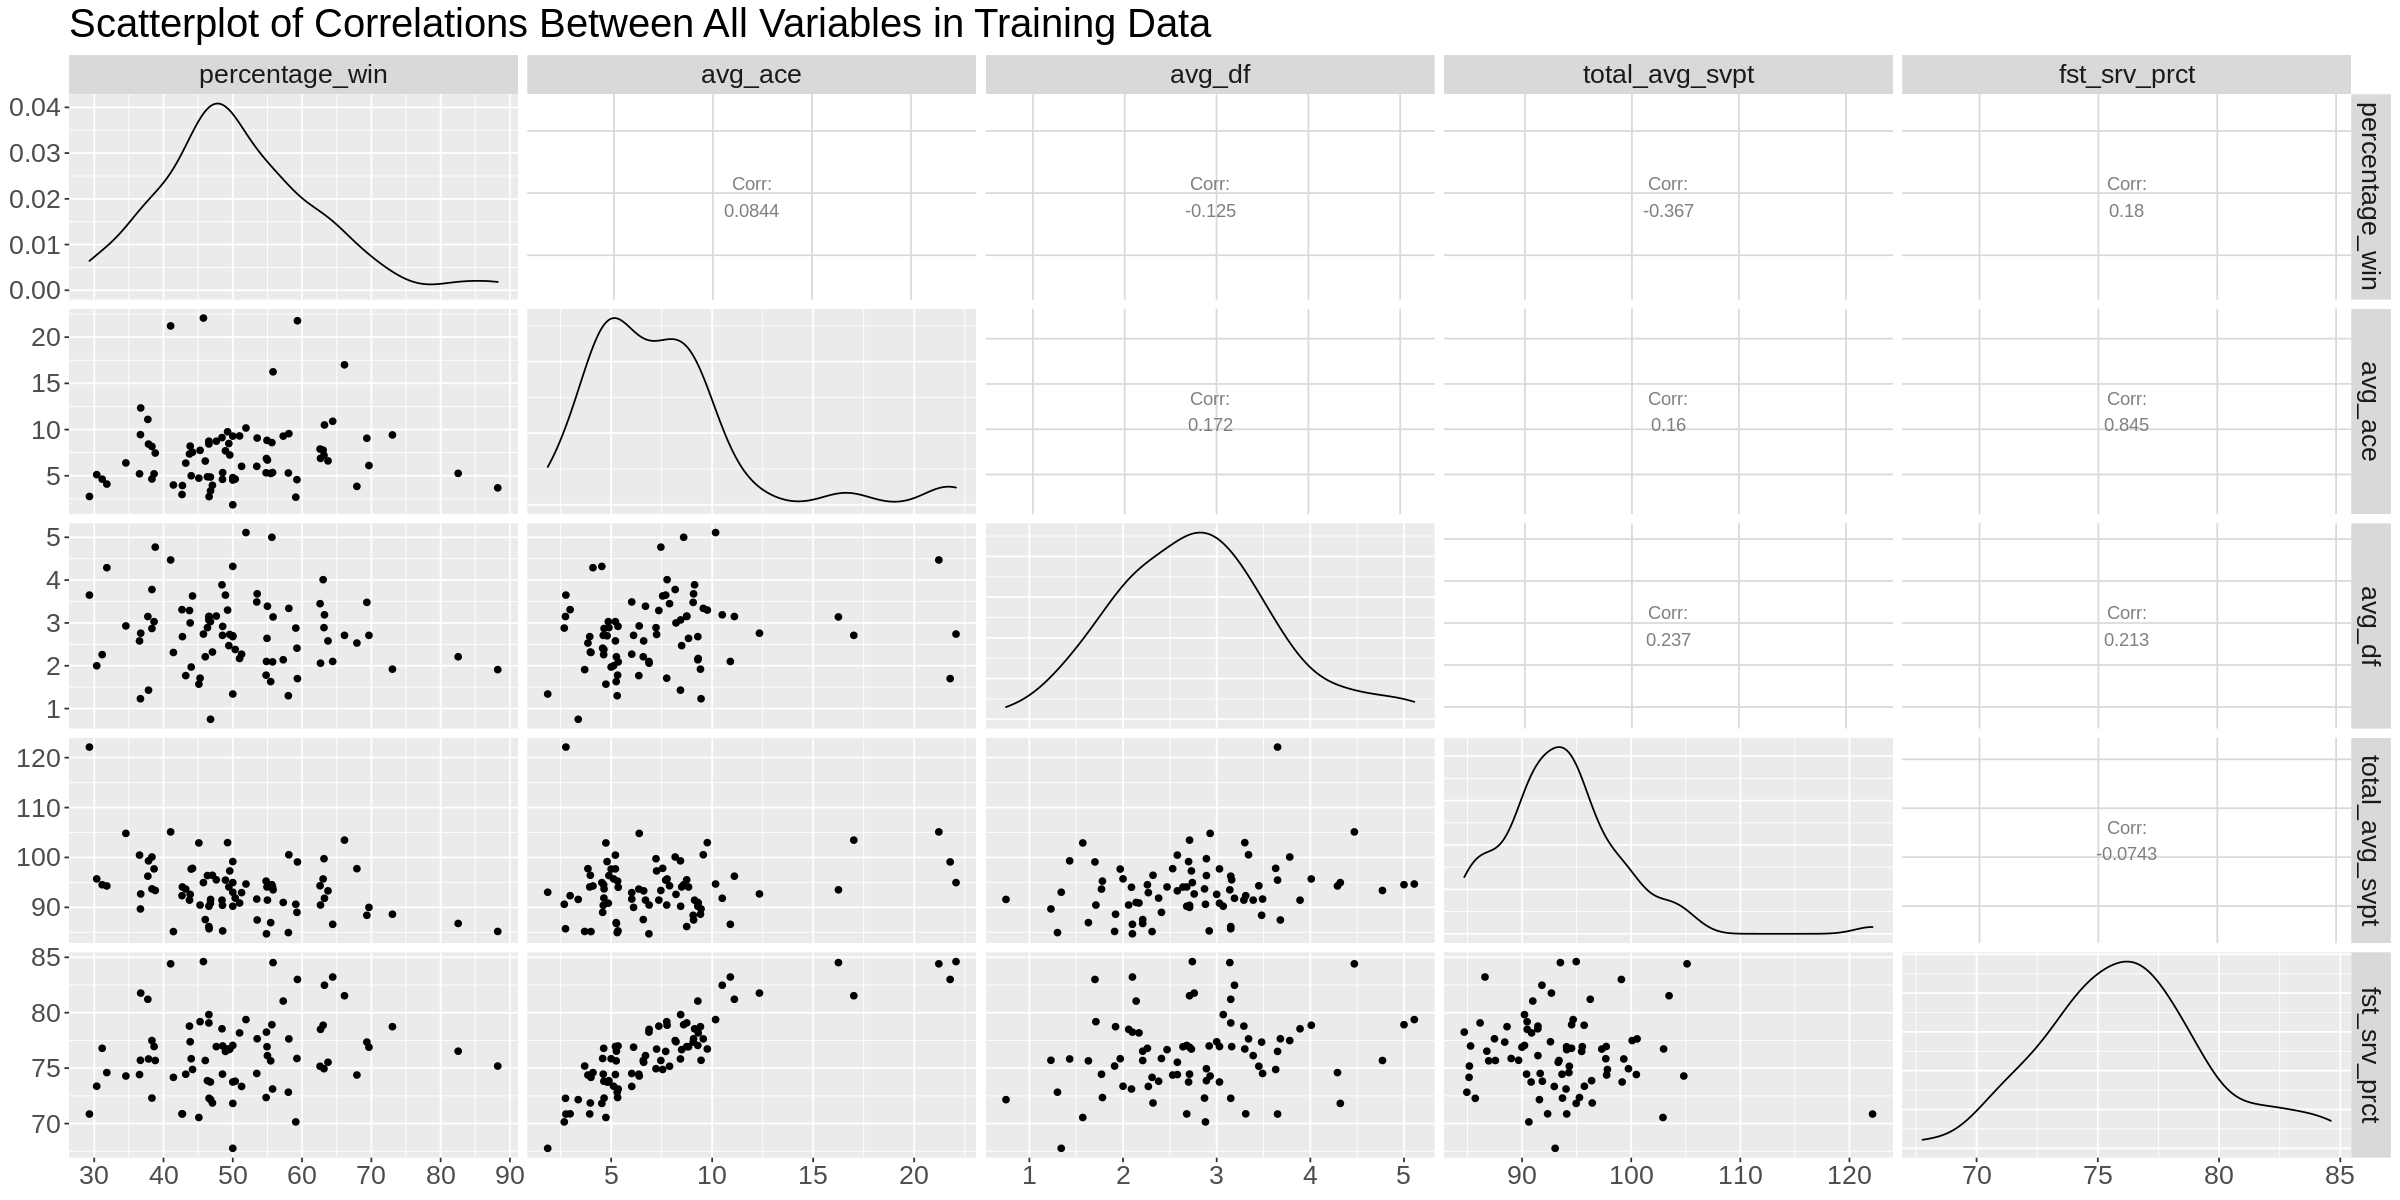

In [217]:
options(repr.plot.width = 20, repr.plot.height = 10)

relationships <- data_train %>%
    ggpairs(columns = 1:ncol(data_train), title = "Scatterplot of Correlations Between All Variables in Training Data", axisLabels = "show") +
#plotting the correlations between all variables against each other in data_train
    theme(text = element_text(size = 20))
    
relationships

##### Graph 1: Scatterplots and Associated Line Plots Between Each Predictor Variable (_avg_ace_: average number of aces scored by winning player; _avg_df_: average number of double faults scored by winning player; _total_avg_svpt_: average total number of successful serves by winning player; _fst_srv_prct_: percentage of successful first serves by winning player) and the Response Variable (_percentage_win_: percentage of wins earned by winning player)

#### Building a KNN Regression Classifier Model

##### Creating a Recipe

In [218]:
recipe <- recipe(percentage_win ~ ., data = data_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

#creating a recipe
#this involves sclaing and centering the predictors in the training data

In order to scale and center the predictors of the data (thus avoiding having one predictor with much more weight than the others), a recipe is created using the training data and the _recipe()_ function in the tidyverse library. _percentage_win_ is the response variable and all other variables are predictors.

In [219]:
folds <- vfold_cv(data_train, v = 10, strata = percentage_win)

#tuning the classifier using validation sets in the training data through 10 folds

The tidymodel _vfold_cv()_ function splits the training data into 10 folds and the _strata_ argument ensures correct proportions of each category of observation in each fold of the training data (i.e. the training and validation subsets contain the right proportions of each category of observation).

In [220]:
model <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

#creating a predictive KNN regression model

An intial KNN regression model is built here where the number of neighbors is not yet decided on: the _tune()_ function is used to assess the model on multiple possible K-values so as to choose one that maxmizes the model's accuracy.
This model utilizes a K-Nearest Neighbours approach ("kknn") due to the non-linear relationship in the data observed in _Graph 1_ and, due to the quantitative nature of the data, is regressive.

In [221]:
rmspe <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(model) %>%
    tune_grid(
        resamples = folds, 
        grid = 100) %>%
    collect_metrics() %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>%
    slice(1) 
rmspe

#calculating the RMSPE value (prediction accuracy) of the KNN model on the validation set

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,rmse,standard,10.69662,10,0.5627384,Model14


##### Table 4: Summary of the Model's Accuracy (RMSPE) Determined by the Mean in Addition to Associated Number of Neighbours (14)

In [232]:
kmin <- rmspe %>%
    pull(neighbors)

#extracting the value of the K-value associated with the smallest error (i.e. smallest RMSPE)

In [223]:
model_14 <- nearest_neighbor(
        weight_func = "rectangular", 
        neighbors = kmin) %>%
    set_engine("kknn") %>%
    set_mode("regression")

#creating a new KNN regression model using the best K-value (14)

In [224]:
workflow <- workflow() %>%
    add_recipe(recipe) %>%
    add_model(model_14) %>%
    fit(data = data_train)

#gathering the multiple analysis steps in the workflow and fitting it using the selected K-value

In [225]:
rmse <- workflow %>%
    predict(data_train) %>%
    bind_cols(data_train) %>%
    metrics(truth = percentage_win, estimate = .pred) %>%
    filter(.metric == "rmse")
rmse

#calculating the RMSE value (prediction accuracy) of the new KNN model on the training set

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,10.19109


In [226]:
summary <- workflow %>%
  predict(data_test) %>%
  bind_cols(data_test) %>%
  metrics(truth = percentage_win, estimate = .pred) %>%
  filter(.metric == "rmse")
summary

##calculating the RMSPE value (prediction accuracy) of the new KNN model on the testing set

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.584716


#### Visualizing the Results of the Analysis

In [227]:
predictions <- workflow %>%
  predict(data_train)%>%
  bind_cols(data_train)

#creating a tibble within which predicted value are shown alongside the true value

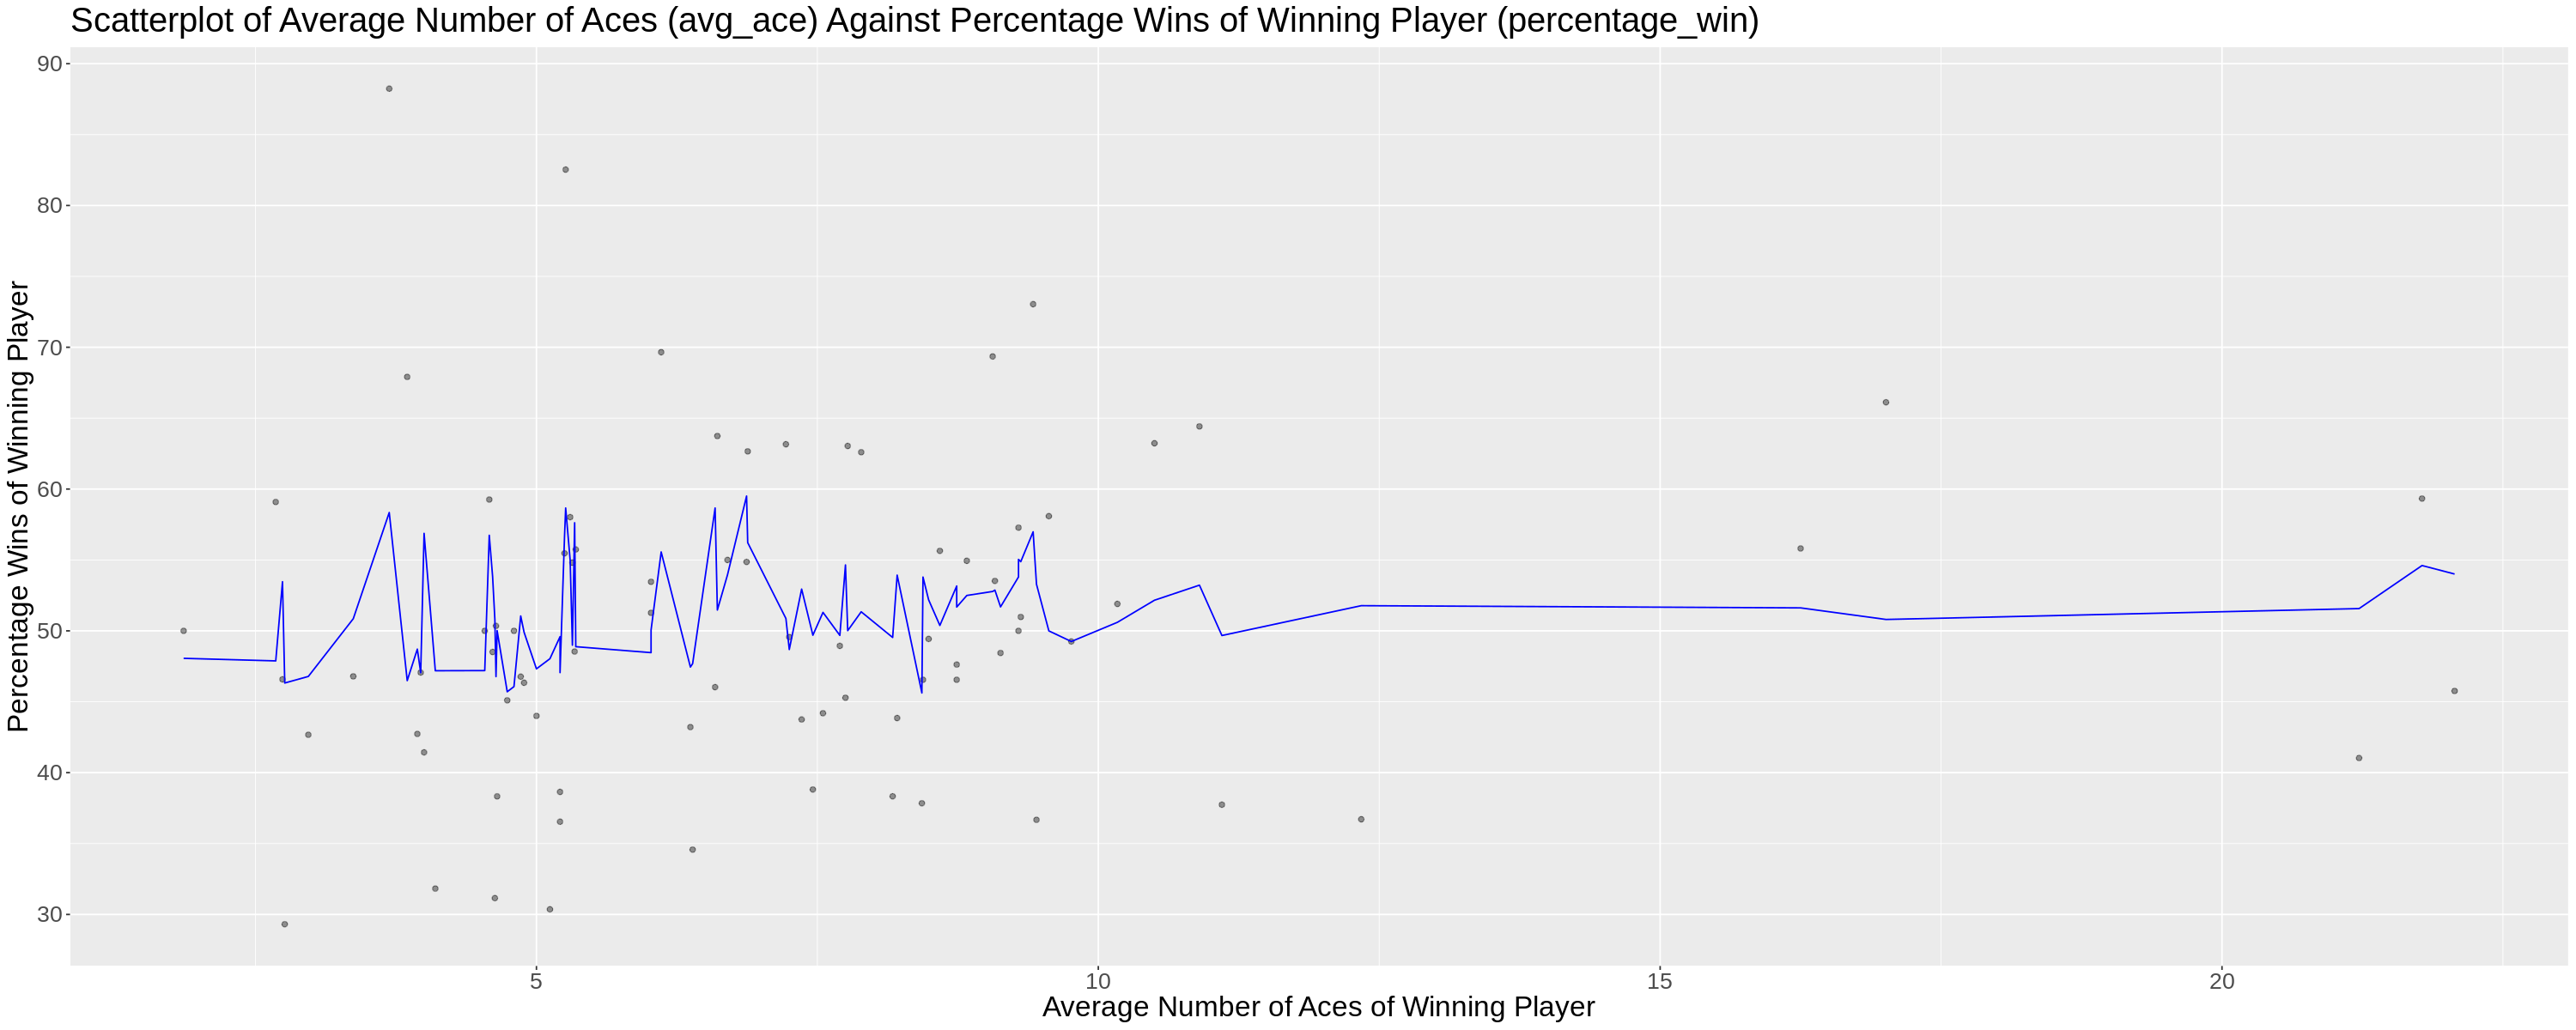

In [228]:
options(repr.plot.width = 25, repr.plot.height = 10)

ace_plot <- ggplot(predictions, aes(x = avg_ace, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Number of Aces of Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = avg_ace, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Number of Aces (avg_ace) Against Percentage Wins of Winning Player (percentage_win)") +
  theme (text = element_text (size = 20))

ace_plot

#graphing each individual predictor against the response variable to evaluate the relationships between them

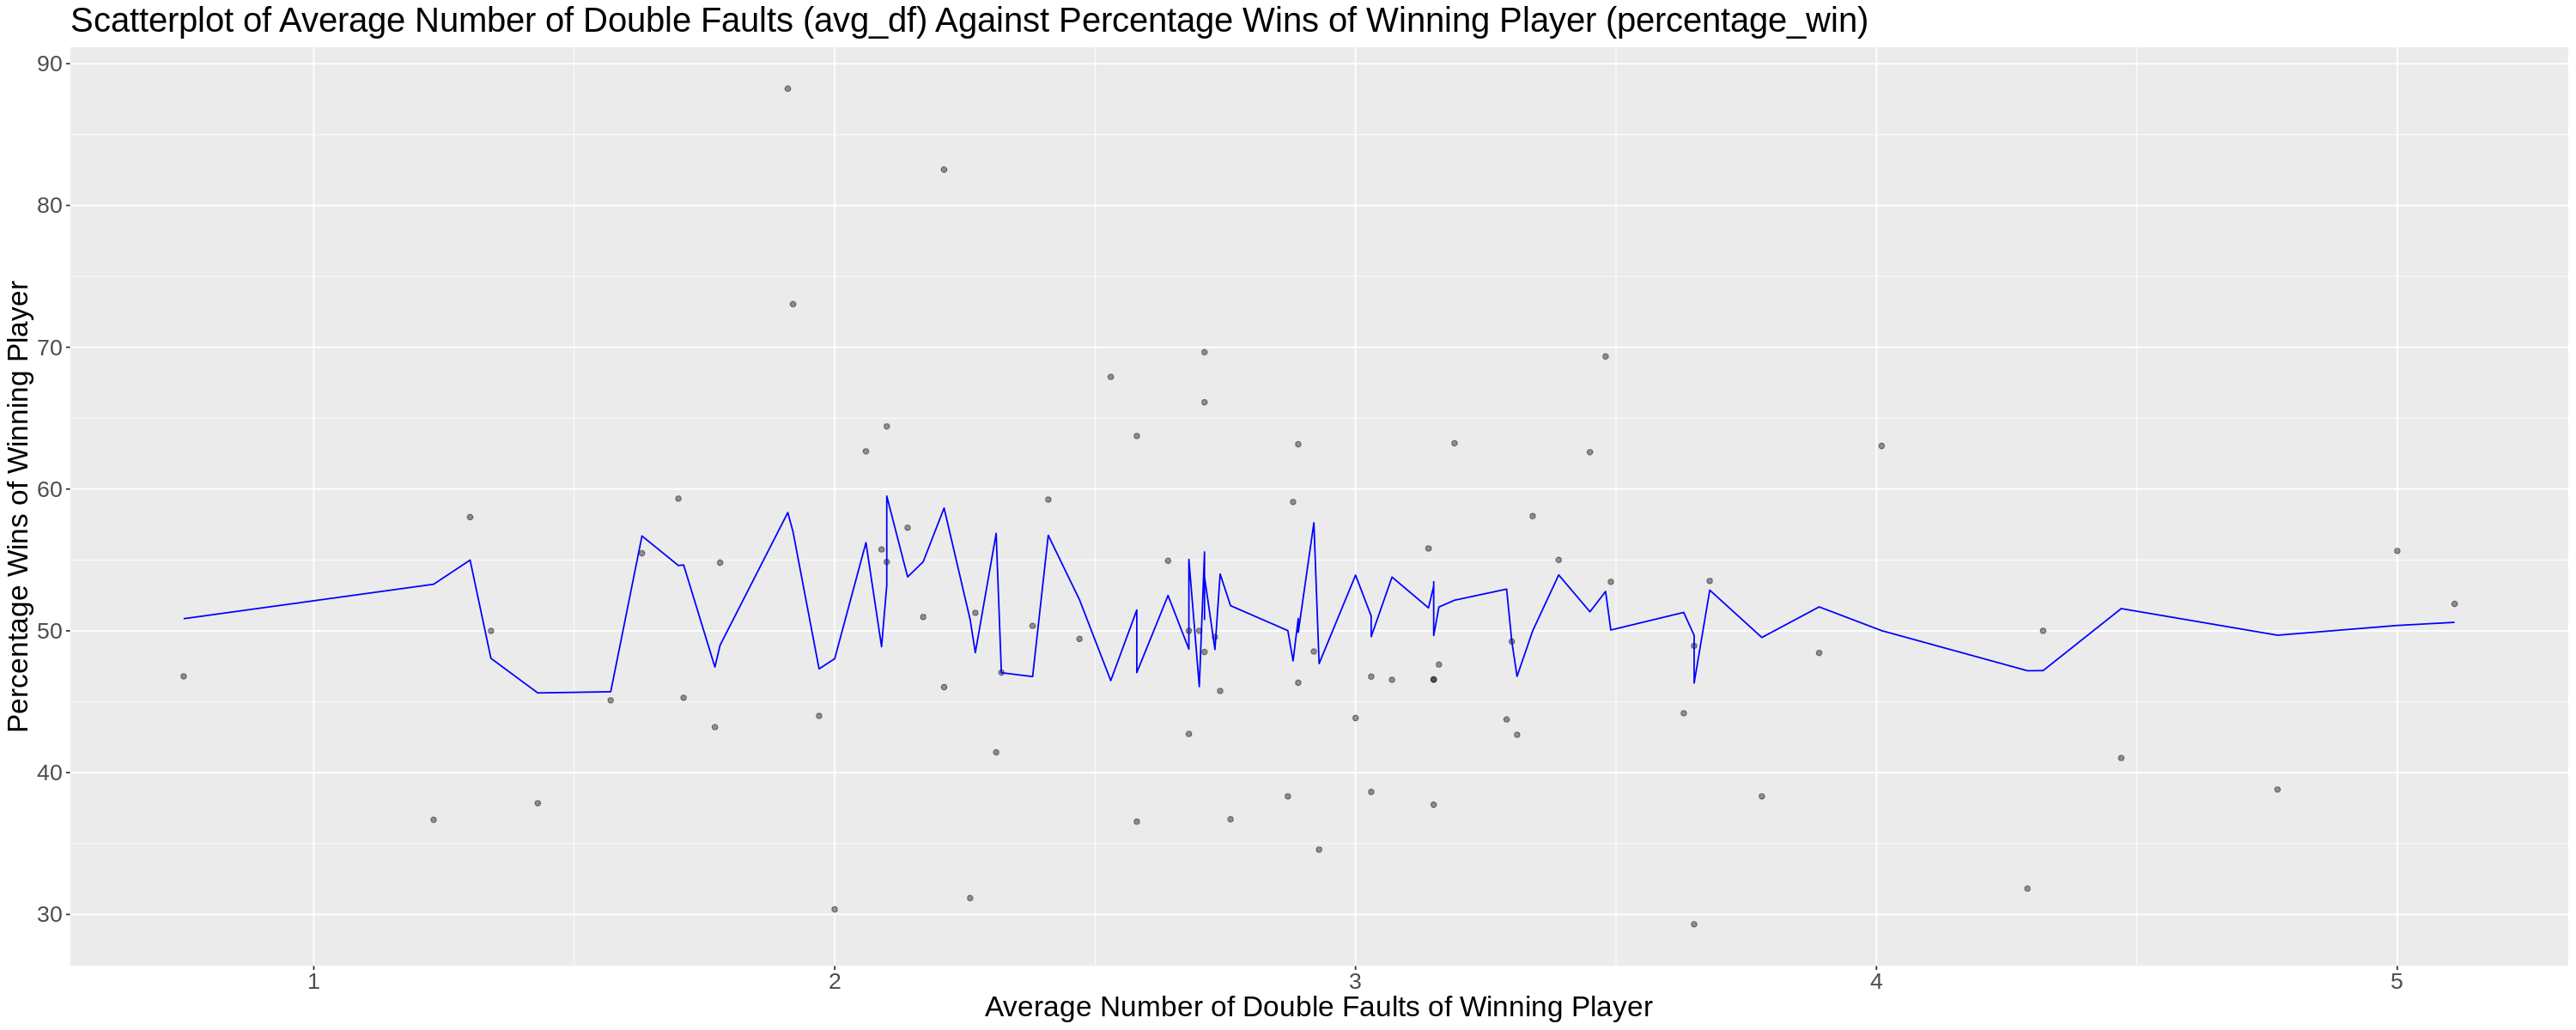

In [229]:
options(repr.plot.width = 25, repr.plot.height = 10)

df_plot <- ggplot(predictions, aes(x = avg_df, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Number of Double Faults of Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = avg_df, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Number of Double Faults (avg_df) Against Percentage Wins of Winning Player (percentage_win)") +
  theme (text = element_text (size = 20))

df_plot

#graphing each individual predictor against the response variable to evaluate the relationships between them

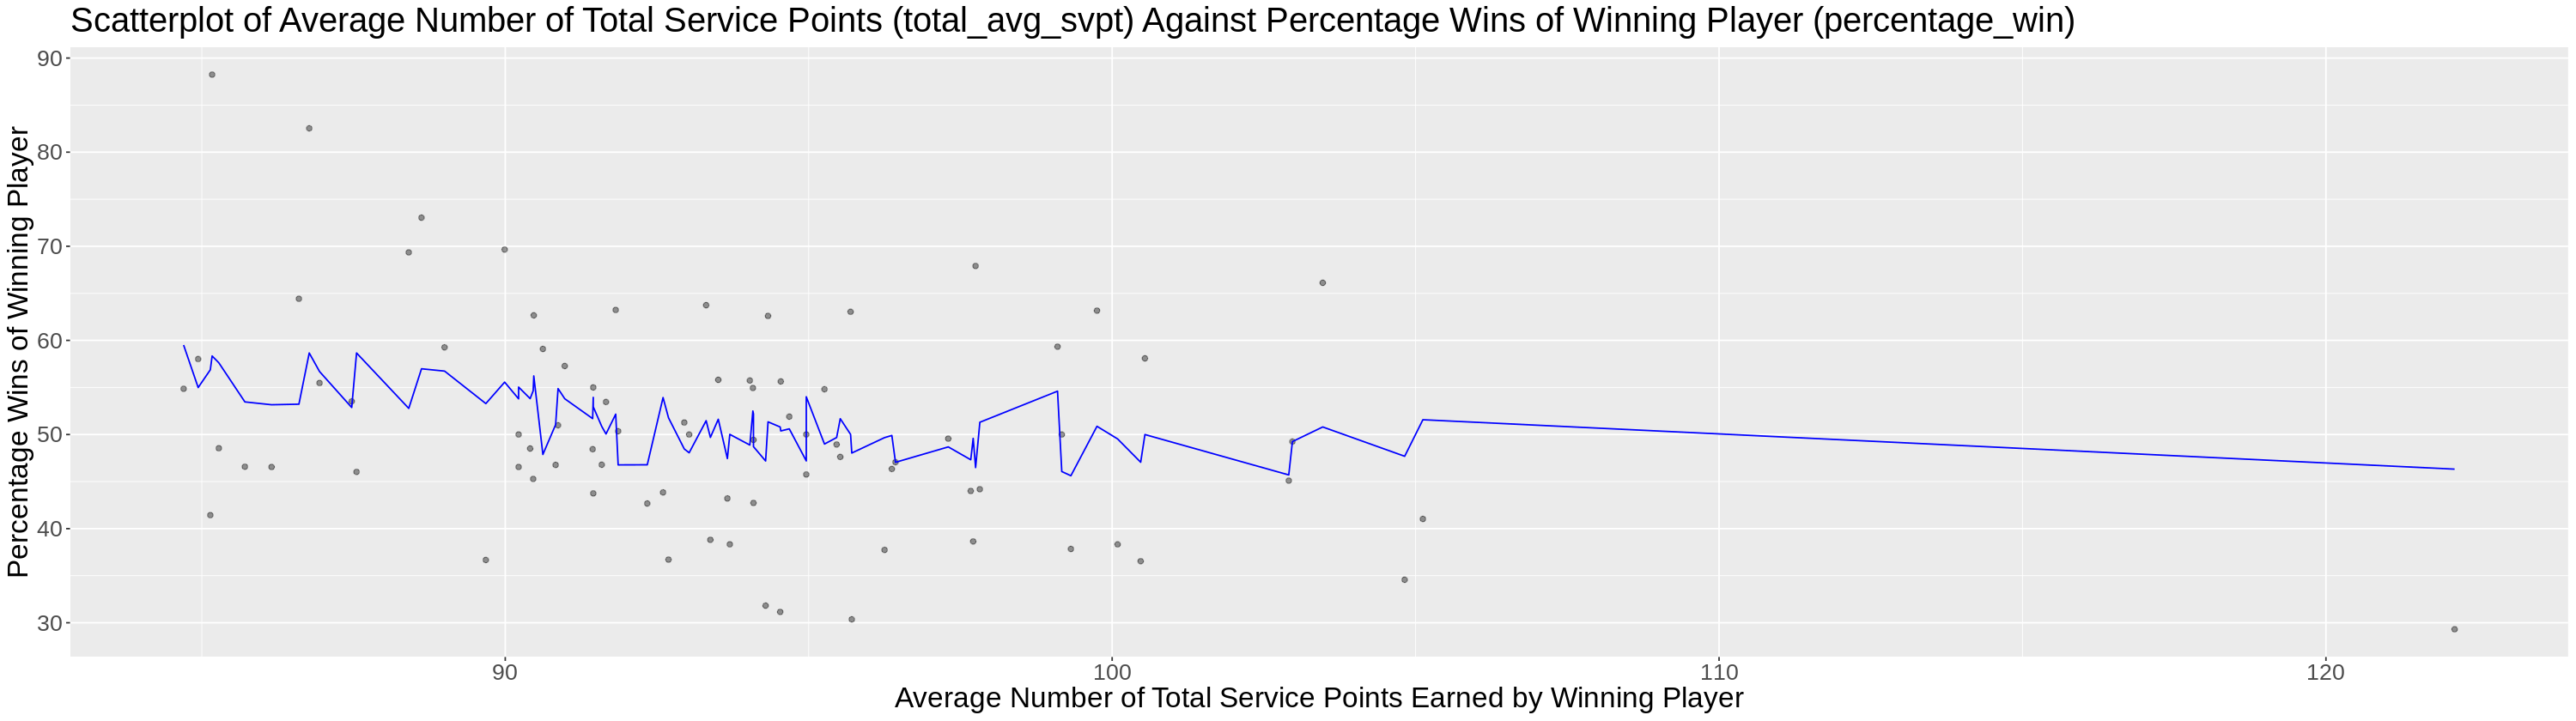

In [230]:
options(repr.plot.width = 25, repr.plot.height = 7)

svpt_plot <- ggplot(predictions, aes(x = total_avg_svpt, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Number of Total Service Points Earned by Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = total_avg_svpt, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Number of Total Service Points (total_avg_svpt) Against Percentage Wins of Winning Player (percentage_win)") +
  theme (text = element_text (size = 20))

svpt_plot

#graphing each individual predictor against the response variable to evaluate the relationships between them

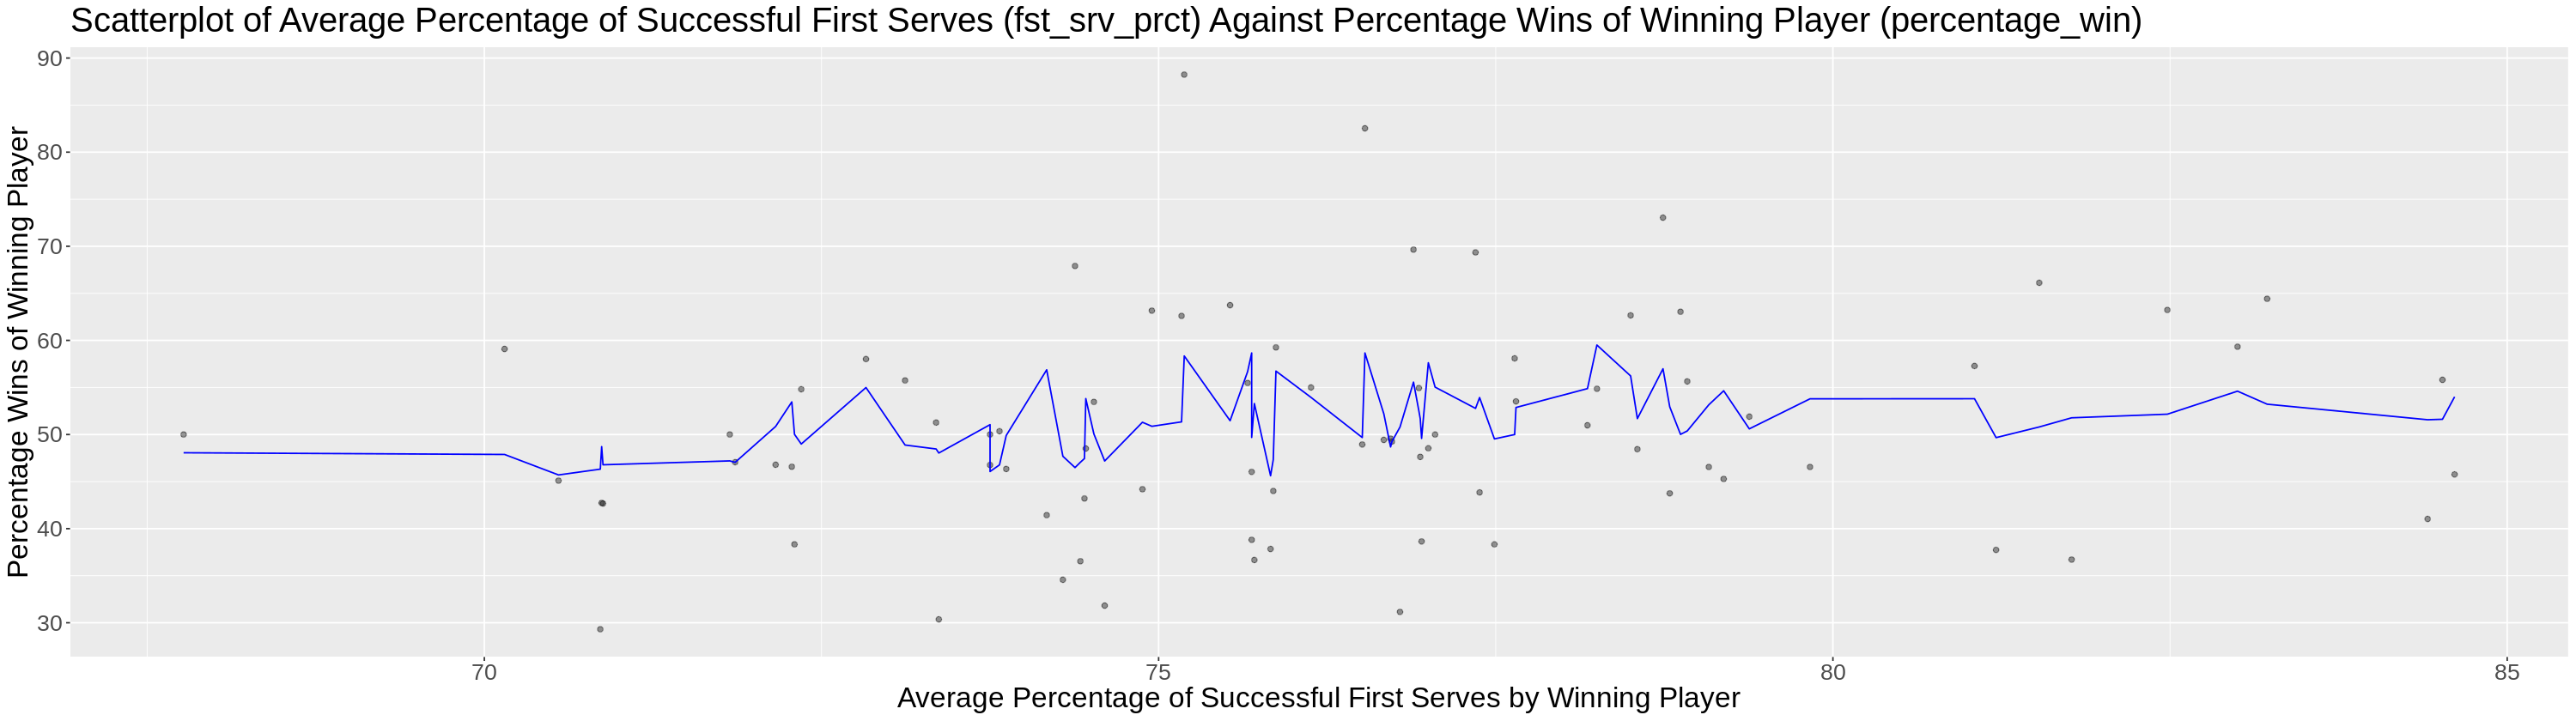

In [231]:
options(repr.plot.width = 25, repr.plot.height = 7)

win_plot <- ggplot(predictions, aes(x = fst_srv_prct, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Percentage of Successful First Serves by Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = fst_srv_prct, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Percentage of Successful First Serves (fst_srv_prct) Against Percentage Wins of Winning Player (percentage_win)") +
  theme (text = element_text (size = 20))

win_plot

#graphing each individual predictor against the response variable to evaluate the relationships between them

### Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

### References